## Work
1. 試比較 save_best_only 與否的差異
##### ANS: save_best_only為True儲存的checkpoint會在loss最低的點
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test
##### ANS: save_weights_only為True的話，需要重建模型，而且還要經過compile才能evaluate

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name="hidden_layer" + str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name="hidden_layer" + str(i+1))(x)
    x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=out)
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
model_ckpt_best = keras.callbacks.ModelCheckpoint(filepath="./best.h5", monitor="val_loss", save_best_only=True)
model_ckpt = keras.callbacks.ModelCheckpoint(filepath="./checkpoint.h5", monitor="val_loss", save_best_only=False)
model_ckpt_onlyw = keras.callbacks.ModelCheckpoint(filepath="./best_onlyw.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_best, model_ckpt, model_ckpt_onlyw]
         )



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,739,402
Trainable params: 1,739,146
Non-trainable params: 256
________________________________________________________________

In [9]:
train_loss = model.history.history['loss']
valid_loss = model.history.history['val_loss']
train_acc = model.history.history['acc']
valid_acc = model.history.history['val_acc']

# Load back
model = keras.models.load_model("./best.h5")
loss_best, acc_best = model.evaluate(x_test, y_test)
model = keras.models.load_model("./checkpoint.h5")
loss_last, acc_last = model.evaluate(x_test, y_test)
model = build_mlp(input_shape=x_train.shape[1:])
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.load_weights("./best_onlyw.h5")
loss_best2, acc_best2 = model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - 1s 86us/step


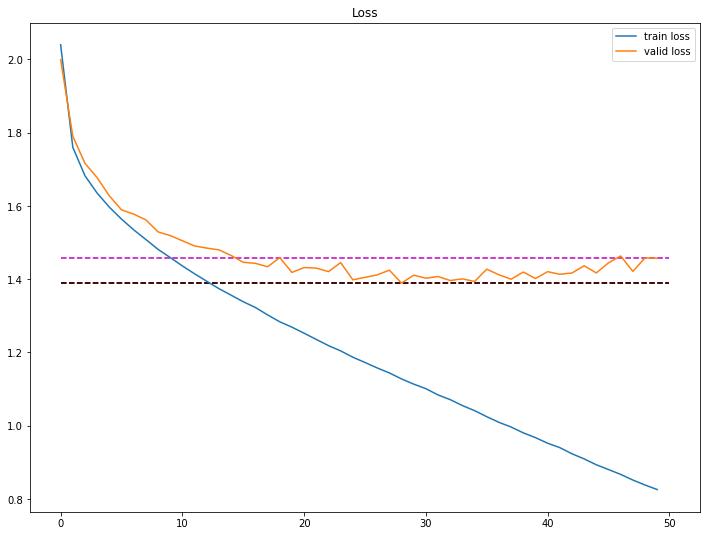

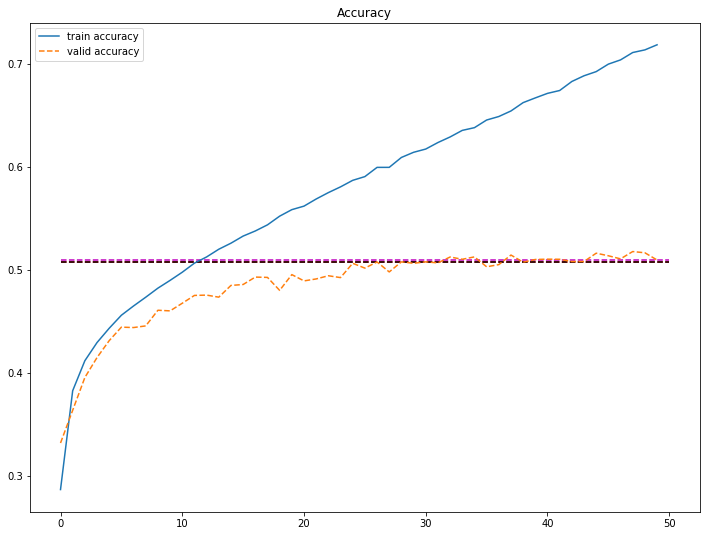

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
plt.figure(figsize=(12, 9))
plt.plot(range(len(train_loss)), train_loss, '-', label='train loss')
plt.plot(range(len(valid_loss)), valid_loss, '-', label='valid loss')
plt.hlines(y=loss_best, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.hlines(y=loss_last, xmin=0, xmax=len(train_loss), colors='m', linestyles='--')
plt.hlines(y=loss_best2, xmin=0, xmax=len(train_loss), colors='k', linestyles='--')
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(range(len(train_acc)), train_acc, '-', label='train accuracy')
plt.plot(range(len(valid_acc)), valid_acc, '--', label='valid accuracy')
plt.hlines(y=acc_best, xmin=0, xmax=len(train_acc), colors='r', linestyles='--')
plt.hlines(y=acc_last, xmin=0, xmax=len(train_acc), colors='m', linestyles='--')
plt.hlines(y=acc_best2, xmin=0, xmax=len(train_acc), colors='k', linestyles='--')
plt.title('Accuracy')
plt.legend()
plt.show()